# Análise de imagens alimentada por IA (Inteligência artificial) para a indústria de energia

### **Metodologia**: Redes Neurais Convolucionais com Transfer learning e fine-tuning


### Inspiração & Direitos de autor

Este projeto é inspirado durante minha aula no curso de visão computacional (Deep learning) avançado na Université Cégep de Matane, lecionado e dirigido por Claude Coulombe:


##### Copyright (c) 2022, Claude Coulombe, Ph.D. em ciência da computação
##### Copyright (c) 2023, Carlos MANDELE, modificações e adaptação para português
O conteúdo deste projeto é licenciado <a href="https://creativecommons.org/licenses/by/4.0/deed.fr" target='_blank'>Creative Commons Attribution 4.0 (CC BY 4.0)</a>,<br/>e os código estão em <a href="https://www.apache.org/licenses/LICENSE-2.0" target='_blank'>licence Apache 2.0</a>.

#### Dados

Os dados originais sobre paineis solares são provinientes da plantaforma <a href="https://www.kaggle.com/datasets/pythonafroz/solar-panel-images/data">Kaggle</a>

* Clean: imagens de painéis solares limpos
* Dusty: imagens de painéis solares empoeirados ou com sujeiras

# Transfer Learning & fine-tuning

## Fixação da aleatoriedade para reprodutibilidade


In [1]:
import os

# Definir um germe aleatório
GERME_ALEATORIO = 42

# Definir um estado aleatório para Python
os.environ['PYTHONHASHSEED'] = str(GERME_ALEATORIO)

# Definir um estado aleatório para Python random
import random
random.seed(GERME_ALEATORIO)

# Definir um estado aleatório para NumPy
import numpy as np
np.random.seed(GERME_ALEATORIO)

# Definir um estado aleatório para TensorFlow
import tensorflow as tf
tf.random.set_seed(GERME_ALEATORIO)

# Nota: Comportamento determinístico removido
# devido a keras.layers.RandomContrast(...)
# dos quais não existe uma versão determinística
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

print("Germe aleatório fixo")

Germe aleatório fixo


## Aquisição dos dados

Os dados podem ser baixados do site do Kaggle. No entanto, para acelerar a transferência de dados usei a (<i>API</i>) do Kaggle.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Criação de diretórios de dados

* Diretório inicial `donnees`,
* Diretório `lab_solarpanel`

* E, um diretório `modeles` memorizar os modelos uma vez treinados.

In [3]:
try:
    os.mkdir("/content/donnees/")
except OSError:
    pass
try:
    os.mkdir("/content/lab_solarpanel/")
except OSError:
    pass
try:
    os.mkdir("/content/modeles/")
except OSError:
    pass

### Uso da API para importação direta de conjuntos de dados

1. Instalando a biblioteca Python `kaggle`

In [4]:
!pip3 install kaggle

2. Criar um diretório na raiz.kaggle e transferência da chave privada « kaggle.json » neste diretório.

In [6]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle -all

mkdir: cannot create directory ‘/root/.kaggle’: File exists
total 16
drwxr-xr-x 2 root root 4096 Nov 15 21:44 .
drwx------ 1 root root 4096 Nov 15 21:44 ..
-rw------- 1 root root   69 Nov 15 21:44 kaggle.json


In [7]:
# Nota! Neste projeto, o conjunto de dados é reduzido para duas classes
!kaggle datasets download carlosmandele/faulty-solar-panel-mini --unzip -p /content/donnees/
diretorio_entrada = "/content/donnees/"

 92% 177M/192M [00:01<00:00, 107MB/s]
100% 192M/192M [00:02<00:00, 100MB/s]


### Repartição do conjunto de dados

In [8]:
# Instalando bibliotecas `split-folders` e `tqdm`
!pip3 install split-folders tqdm

In [9]:
# Divisão do conjunto de dados de treinamento, validação e teste
import splitfolders
import pathlib

diretorio_donnees_reparties = "/content/lab_solarpanel"
# => train, val, test

numero_imagens = len(list(pathlib.Path(diretorio_entrada).glob('*/*.jpg')))
print("Número total de imagens:",numero_imagens)

splitfolders.ratio(diretorio_entrada,
                   output=diretorio_donnees_reparties,
                   seed=42,
                   ratio = (0.65, 0.15, 0.20)
                   )

print("\nDetalhamento de dados concluído!")


Número total de imagens: 373


Copying files: 385 files [00:00, 1626.72 files/s]


Detalhamento de dados concluído!


### Visualisation d'un échantillon des données

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg



### Criando feeds de lote de dados

* Carregando imagens na memória `tf.data.dataset` utilizando a injeção `tf.keras.utils.image_dataset_from_directory`.

**Nota:** Dado que, `tf.data.Dataset` suporta a escrita de cadeias de processamento de dados eficientes. A iteração ocorre em um fluxo contínuo, portanto, todo o conjunto de dados não precisa caber na memória.

In [12]:
import os
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
print("Versão Keras:",keras.__version__)
import tensorflow as tf
print("Versão TensorFlow :",tf.__version__)

DIRETORIO_TREINO = "/content/lab_solarpanel/train/"
DIRETORIO_VALIDATION = "/content/lab_solarpanel/val"
DIRETORIO_TESTE = "/content/lab_solarpanel/test/"

TAILLE_LOT = 32
HAUTEUR_IMAGE = 150
LARGEUR_IMAGE = 150
TAILLE_IMAGE = (HAUTEUR_IMAGE, LARGEUR_IMAGE)
NUMERO_CANAIS = 3

Versão Keras: 2.14.0
Versão TensorFlow : 2.14.0


In [13]:
# Fluxo de dados para treinamento
dados_treino = tf.keras.utils.image_dataset_from_directory(DIRETORIO_TREINO,
                                                                   batch_size=TAILLE_LOT,
                                                                   image_size=TAILLE_IMAGE)

Found 249 files belonging to 2 classes.


In [14]:
print("Tipo Python dados_treino):",type(dados_treino))
flux_imagens, flux_rotulos = next(iter(dados_treino))
print("Dimensões do fluxo de imagens:",flux_imagens.shape)
print("Número de imagens):",len(flux_imagens))
print("Dimensões do fluxo de rótulos:",flux_rotulos.shape)
print("Número de rótulos):",len(flux_rotulos))

Tipo Python dados_treino): <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
Dimensões do fluxo de imagens: (32, 150, 150, 3)
Número de imagens): 32
Dimensões do fluxo de rótulos: (32,)
Número de rótulos): 32


In [16]:
# Recuperando nomes de classe ou rótulos
liste_noms_classes = dados_treino.class_names
print(liste_noms_classes)
# Cálculo do número de classes
numero_de_classes = len(liste_noms_classes)
print('Número de classes:',numero_de_classes)

['Clean', 'Dusty']
Número de classes: 2


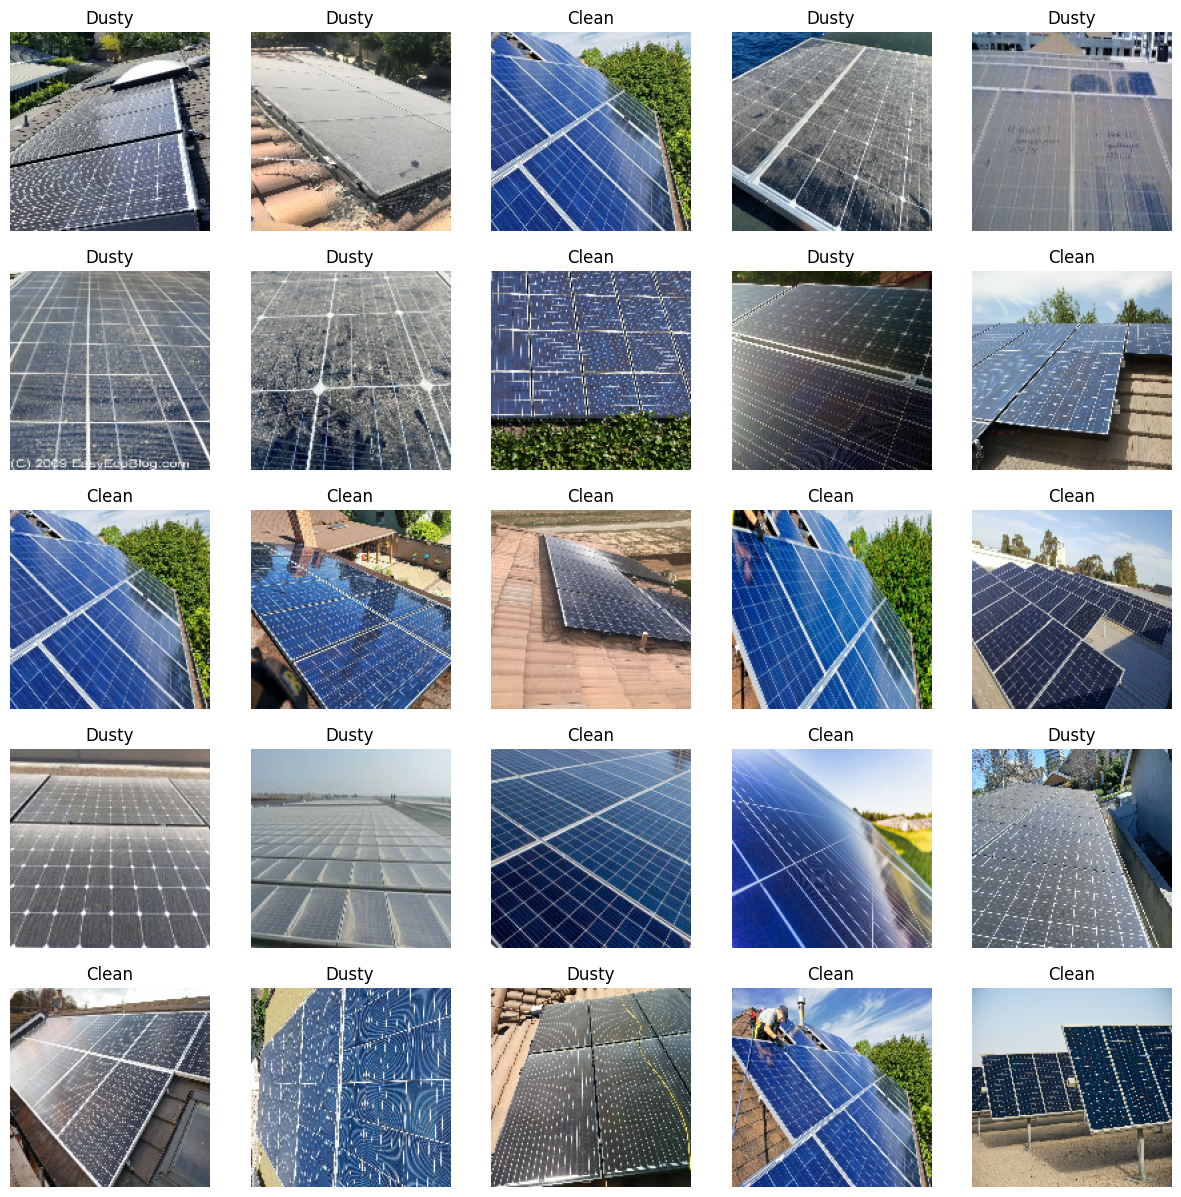

In [59]:
plt.figure(figsize=(15, 15))
for images, labels in dados_treino.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(liste_noms_classes[labels[i]])
        plt.axis("off")

In [17]:
# Fluxo de dados para validação
dados_validation = tf.keras.utils.image_dataset_from_directory(DIRETORIO_VALIDATION,
                                                                 batch_size=TAILLE_LOT,
                                                                 image_size=TAILLE_IMAGE)

Found 57 files belonging to 2 classes.


In [18]:
# Fluxo de dados para teste
dados_test = tf.keras.utils.image_dataset_from_directory(DIRETORIO_TESTE,
                                                           batch_size=TAILLE_LOT,
                                                           image_size=TAILLE_IMAGE)

Found 77 files belonging to 2 classes.


In [19]:
print("Número de lotes de dados de treinamento: %d" % tf.data.experimental.cardinality(dados_treino ))
print("Número de lotes de dados de validação: %d" % tf.data.experimental.cardinality(dados_validation))
print('Número de lotes de dados de teste: %d' % tf.data.experimental.cardinality(dados_test))


Número de lotes de dados de treinamento: 8
Número de lotes de dados de validação: 2
Número de lotes de dados de teste: 3


## Pré-processamento de dados

### Normalização de dados

In [20]:
camadas_normalisation = keras.Sequential([
    # Redimensionamento da imagem e escala de luminosidade
    keras.layers.Resizing(HAUTEUR_IMAGE,LARGEUR_IMAGE),
    keras.layers.Rescaling(1./255)
])

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

def pre_tratamento(conjut_dados, melanger=False, normaliser=False):
    if melanger:
        conjut_dados = conjut_dados.shuffle(1000)

    if normaliser:
        conjut_dados = conjut_dados.map(lambda x, y: (camadas_normalisation(x), y),
                                    num_parallel_calls=AUTOTUNE
                                    )
    # Buffers de pré-busca em todos os conjuntos de dados
    return conjut_dados.prefetch(buffer_size=AUTOTUNE)

print("Pronto para a função de pré-tratamento!")

Pronto para a função de pré-tratamento!


#### Normalização de dados de treinamento

In [22]:
print("Tipo Python dados_treino):",type(dados_treino))
dados_treino_normalisees = pre_tratamento(dados_treino,
                                                 melanger=True,
                                                 normaliser=True)
print("Tipo Python dados_treino_normalisees):",type(dados_treino_normalisees))

Tipo Python dados_treino): <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
Tipo Python dados_treino_normalisees): <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


#### Normalização de dados de validação

In [23]:
print("Tipo Python de dados_validation):",type(dados_validation))
dados_validation_normalisees = pre_tratamento(dados_validation,
                                               melanger=False,
                                               normaliser=True)
print("Tipo Python dados_validation_normalisees):",type(dados_validation_normalisees))

Tipo Python de dados_validation): <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
Tipo Python dados_validation_normalisees): <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


#### Normalização de dados de teste

In [24]:
print("Tipo Python de dados_test):",type(dados_test))
AUTOTUNE = tf.data.AUTOTUNE
dados_test = dados_test.cache().prefetch(buffer_size=AUTOTUNE)
print("Tipo Python de dados_test):",type(dados_test))
dados_test_normalisees = dados_test.map(lambda x, y: (camadas_normalisation(x), y))
print("Tipo Python de dados_test_normalisees:",type(dados_test_normalisees))

Tipo Python de dados_test): <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
Tipo Python de dados_test): <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
Tipo Python de dados_test_normalisees: <class 'tensorflow.python.data.ops.map_op._MapDataset'>


## Criando um modelo de aprendizagem por transferência

### Importando um modelo `inception` pré-treinado em `ImageNet`

In [25]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


--2023-11-15 21:48:20--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.103.207, 108.177.120.207, 142.250.128.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.103.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   178MB/s    in 0.5s    

2023-11-15 21:48:20 (178 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [34]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Ajuste das configurações ou pesos do modelo InceptionV3 pré-treinado
modelo_pretreinado = InceptionV3(weights='imagenet',
                                 input_shape = (HAUTEUR_IMAGE,LARGEUR_IMAGE,NUMERO_CANAIS),
                                 include_top = False)


In [27]:
print("Arquitetura de modelo pré-treinada")
modelo_pretreinado.summary()

Arquitetura de modelo pré-treinada
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)     

### Módulo de extração de atributos visuais

#### Determinação da camada de saída e a camada onde o ajuste fino (`fine-tuning)` começa

In [28]:
modelo_pretreinado.trainable = True

# Número de camadas existentes no modelo pré-treinado
# Índice de camada a partir do ID da camada
# Escolhendo uma nova camada de saída por tentativa e erro
# Escolhendo a última camada não treinável ou a última camada « congelada » do modelo pré-treinado
# Ajuste do treino a partir da última camada não treinável
numero_camadas_modelo_pretreinado = len(modelo_pretreinado.layers)
print("Número de camadas no modelo original pré-treinado: ", numero_camadas_modelo_pretreinado)
liste_noms_de_camadas = [camada.name for camada in modelo_pretreinado.layers]
nome_ultima_camada = liste_noms_de_camadas[-1]
print("Nome da última camada do modelo completo pré-treinado:",nome_ultima_camada)
index_ultima_camada = liste_noms_de_camadas.index(nome_ultima_camada)
print("Índice da última camada do modelo completo pré-treinado:",index_ultima_camada)
nome_ultima_camada = 'mixed5'
print("Escolha empírica da última camada do modelo pré-treinado:",nome_ultima_camada)
index_ultima_camada = liste_noms_de_camadas.index(nome_ultima_camada)
print("Índice da última camada do modelo pré-treinado escolhido empiricamente:",index_ultima_camada)

nome_ultima_camada_congelada = 'mixed3'
print("Escolha empírica da última camada não treinável:",nome_ultima_camada_congelada)
index_ultima_camada_congelada = liste_noms_de_camadas.index(nome_ultima_camada_congelada)
print("Índice da última camada não treinável:",index_ultima_camada_congelada)
start_paufinage = index_ultima_camada_congelada
print("Número de camadas congeladas (não treináveis) no modelo pré-treinado: ", start_paufinage )
# Congelando todas as camadas antes `start_paufinage`
for camada in modelo_pretreinado.layers[:start_paufinage]:
    camada.trainable =  False
print("Número de camadas treináveis no modelo pré-treinado: ", index_ultima_camada-start_paufinage)
ultima_camada = modelo_pretreinado.get_layer(nome_ultima_camada)
print('Dimensões da última camada: ', ultima_camada.output_shape)
saida_ultima_camada = ultima_camada.output


Número de camadas no modelo original pré-treinado:  311
Nome da última camada do modelo completo pré-treinado: mixed10
Índice da última camada do modelo completo pré-treinado: 310
Escolha empírica da última camada do modelo pré-treinado: mixed5
Índice da última camada do modelo pré-treinado escolhido empiricamente: 164
Escolha empírica da última camada não treinável: mixed3
Índice da última camada não treinável: 100
Número de camadas congeladas (não treináveis) no modelo pré-treinado:  100
Número de camadas treináveis no modelo pré-treinado:  64
Dimensões da última camada:  (None, 7, 7, 768)


### Módulo de *classificação*

#### Perceptron MLP

In [29]:
# Camada de regularização de extinção de neurônio (dropout)
# Nivel da camada de saída em um vetor
# Camada de saída totalmente conectada de 20 neurônios
# com ativação softmax (exponencial normalizada)
saidas = layers.Dropout(0.2)(saida_ultima_camada)
saidas = layers.Flatten()(saidas)
saidas = layers.Dense(1024, activation='relu')(saidas)
saidas = layers.Dropout(0.2)(saidas)
saidas = layers.Dense(numero_de_classes, activation='softmax')(saidas)
modelo_transfert = Model(modelo_pretreinado.input, saidas)
print("Número de camadas no modelo de aprendizagem de transferência: ", len(modelo_transfert.layers))


Número de camadas no modelo de aprendizagem de transferência:  170


In [30]:
print("Arquitetura completa")
modelo_transfert.summary()

Arquitetura completa
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['bat

In [31]:
print("Número de parâmetros treináveis no modelo de transferência: ",len(modelo_transfert.trainable_variables))


Número de parâmetros treináveis no modelo de transferência:  44


## Compilando o modelo

In [35]:
from tensorflow.keras.optimizers import RMSprop


modelo_transfert.compile(optimizer = RMSprop(learning_rate=0.0001),
                            loss = 'sparse_categorical_crossentropy',
                            metrics = ['accuracy'])

print("Modelo compilado!")


Modelo compilado!


## Treinamento de modelo

In [37]:
nemero_iterations_de_base = 10
numero_iterations_peaufinage = 20
numero_total_iterations =  nemero_iterations_de_base + numero_iterations_peaufinage


lista_fonctions_chamadas = [
    keras.callbacks.ModelCheckpoint(
        filepath="EnergAI_ResConv_TransAmpl.tf",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        # Monitor da precisão da validação
        monitor='val_accuracy',
        patience=11,
        verbose=2),
    # Ajuste aa taxa de aprendizagem/ganho de gradiente
    keras.callbacks.ReduceLROnPlateau(
        # Monitor de erro de validação
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=2)
]

traces_treino = modelo_transfert.fit(dados_treino_normalisees,
                                              validation_data = dados_validation_normalisees,
                                              epochs = numero_total_iterations,
                                              callbacks = lista_fonctions_chamadas,
                                              verbose = 2)


Epoch 1/30
8/8 - 20s - loss: 0.1161 - accuracy: 0.9398 - val_loss: 0.4880 - val_accuracy: 0.7719 - lr: 1.0000e-04 - 20s/epoch - 3s/step
Epoch 2/30
8/8 - 7s - loss: 0.0251 - accuracy: 0.9960 - val_loss: 1.0007 - val_accuracy: 0.7193 - lr: 1.0000e-04 - 7s/epoch - 867ms/step
Epoch 3/30
8/8 - 5s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 1.1707 - val_accuracy: 0.6316 - lr: 1.0000e-04 - 5s/epoch - 611ms/step
Epoch 4/30

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
8/8 - 6s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.2971 - val_accuracy: 0.6491 - lr: 1.0000e-04 - 6s/epoch - 789ms/step
Epoch 5/30
8/8 - 6s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.9632 - val_accuracy: 0.7544 - lr: 5.0000e-05 - 6s/epoch - 736ms/step
Epoch 6/30
8/8 - 7s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.0968 - val_accuracy: 0.7368 - lr: 5.0000e-05 - 7s/epoch - 816ms/step
Epoch 7/30

Epoch 7: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
8/8 - 6s - los

### Exibição de curvas de treinamento

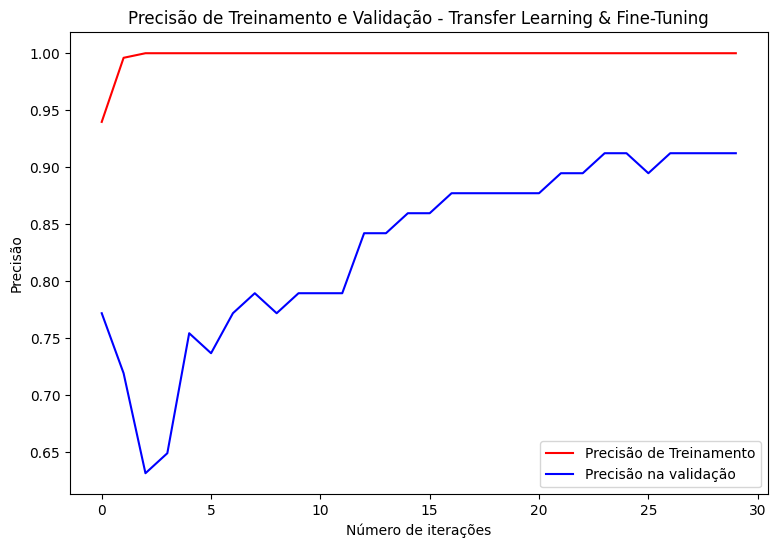

In [38]:
import matplotlib.pyplot as plt
desempenho_treino = traces_treino.history['accuracy']
desempenho_validation = traces_treino.history['val_accuracy']
erro_treino = traces_treino.history['loss']
erro_validation = traces_treino.history['val_loss']
numero_iterations = range(len(desempenho_treino))
numero_dor = 1.618
altur = 6
longueur = int(numero_dor * altur)
plt.figure(figsize=(longueur,altur))
plt.plot(numero_iterations, desempenho_treino, 'r', label='Precisão de Treinamento')
plt.plot(numero_iterations, desempenho_validation, 'b', label='Precisão na validação')
plt.title("Precisão de Treinamento e Validação - Transfer Learning & Fine-Tuning")
plt.legend(loc=0)
plt.xlabel("Número de iterações")
plt.ylabel("Precisão")
plt.show()


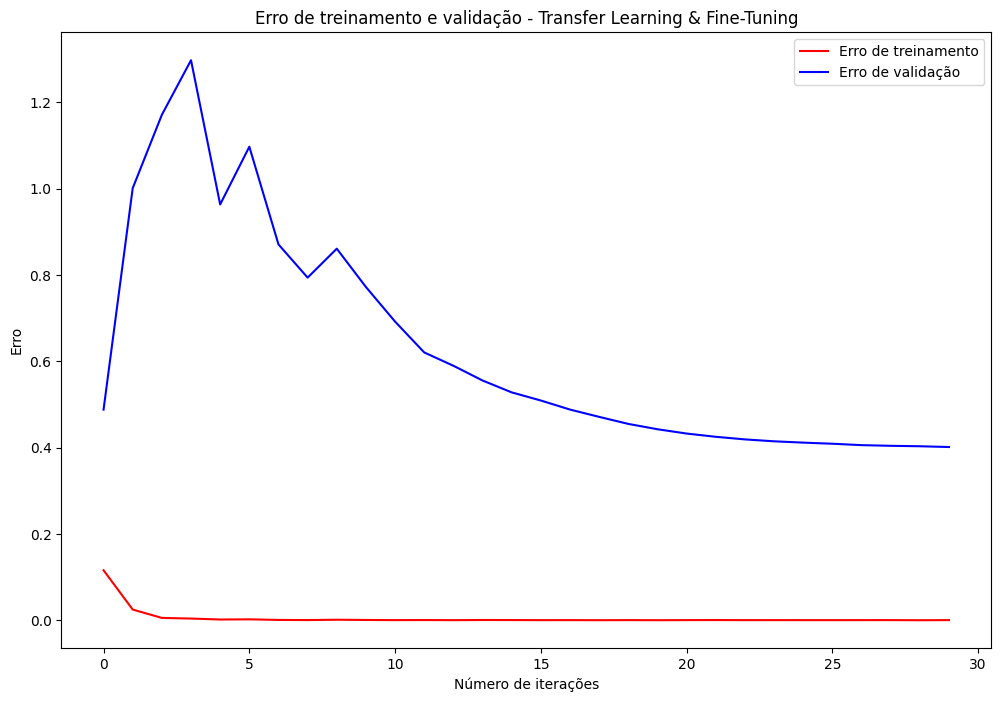

In [39]:
import matplotlib.pyplot as plt
erro_treino = traces_treino.history['loss']
erro_validation = traces_treino.history['val_loss']
numero_iterations = range(len(desempenho_treino))
numero_dor = 1.62
altur = 8
longueur = int(numero_dor * altur)
plt.figure(figsize=(longueur,altur))
plt.plot(numero_iterations, erro_treino, 'r', label="Erro de treinamento")
plt.plot(numero_iterations, erro_validation, 'b', label="Erro de validação")
plt.title("Erro de treinamento e validação - Transfer Learning & Fine-Tuning")
plt.legend(loc=0)
plt.xlabel("Número de iterações")
plt.ylabel("Erro")
plt.show()

### Validação do modelo com os dados de teste

In [40]:
erro_test, desempenho_test = modelo_transfert.evaluate(dados_test_normalisees)
print("Precisão nos dados de teste: %0.2f" % desempenho_test)


3/3 [==============================] - 2s 351ms/step - loss: 0.5192 - accuracy: 0.8442
Precisão nos dados de teste: 0.84


## Resultados obtidos

Os resultados obtidos situam-se no intervalo de 75 à 80 % para o conjunto de dados `Faulty solar panel mini`.

### Análise dos resultados dos dados de teste

#### Previsões sobre dados de teste

Extraindo rótulos previstos

In [41]:
predictions = modelo_transfert.predict(dados_test_normalisees)
index_predictions = np.argmax(predictions, axis=1)
liste_rotulos_prev = [(rotulo+1) for rotulo in index_predictions]
print(liste_rotulos_prev)


3/3 [==============================] - 1s 32ms/step
[2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2]


Extraindo rótulos reais

In [42]:
index_real_rotulos = list(np.concatenate([rotulo for image, rotulo in dados_test_normalisees], axis=0))
liste_real_rotulos = [(rotulo+1) for rotulo in index_real_rotulos]
print(liste_real_rotulos)


[2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1]


Calculando a precisão nos dados de teste



In [43]:
from sklearn import metrics

precision_test = metrics.accuracy_score(liste_real_rotulos, liste_rotulos_prev)
print("Precisão:   %0.2f" % precision_test)


Precisão:   0.84


#### Exibindo uma matriz de confusão

Código de exibição da matriz de confusão


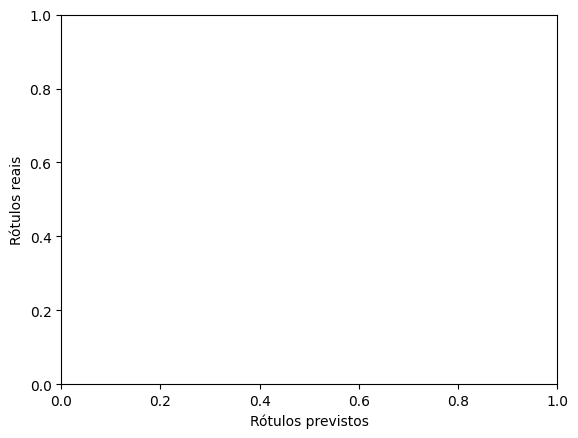

In [55]:
import itertools

def exibir_matriz_de_confusion(matriz_confusion_brute, classes,
                          normalisation=False,
                          titulo='Matriz de confusão',
                          map_couleurs=plt.cm.Blues):
    plt.figure(figsize=(14,12))
    plt.imshow(matriz_confusion_brute, interpolation='nearest', cmap=map_couleurs)
    plt.title(titulo)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalisation:
       matriz_confusion_brute = matriz_confusion_brute.astype('float') / matriz_confusion_brute.sum(axis=1)[:, np.newaxis]
       print("Matriz de confusão normalizada")
    else:
      print('Matriz de confusão não normalizada')

    limi = matriz_confusion_brute.max() / 2.
    for i, j in itertools.product(range(matriz_confusion_brute.shape[0]), range(matriz_confusion_brute.shape[1])):
        plt.text(j, i, matriz_confusion_brute[i, j],
                 horizontalalignment="center",
                 color="white" if matriz_confusion_brute[i, j] > limi else "black")


plt.tight_layout()
plt.ylabel('Rótulos reais')
plt.xlabel('Rótulos previstos')



print("Código de exibição da matriz de confusão")

Matriz de confusão não normalizada


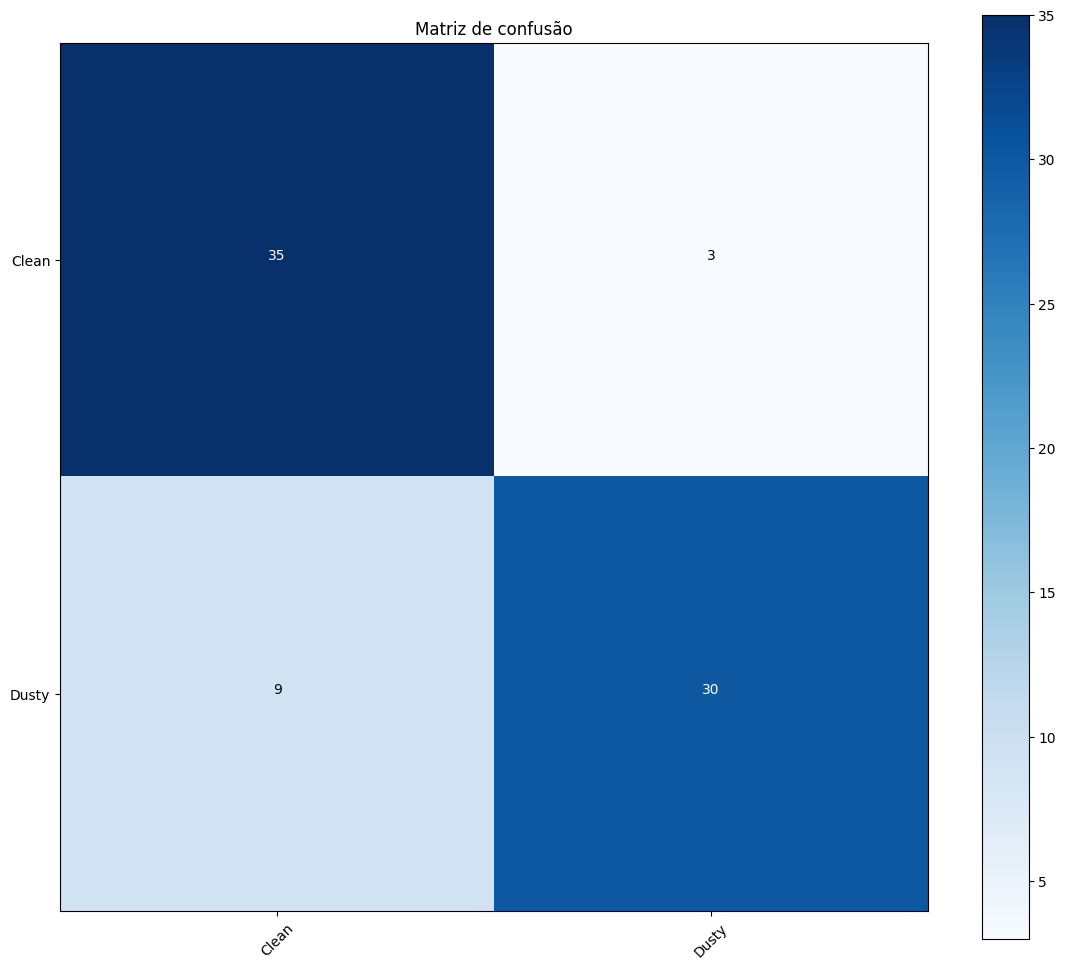

In [56]:
matriz_confusion_brute = metrics.confusion_matrix(liste_real_rotulos , liste_rotulos_prev)
exibir_matriz_de_confusion(matriz_confusion_brute, classes=liste_noms_classes)


#### Relatório de Classificação

In [57]:
from sklearn.metrics import classification_report

print(classification_report(liste_real_rotulos, liste_rotulos_prev, target_names=liste_noms_classes))


              precision    recall  f1-score   support

       Clean       0.80      0.92      0.85        38
       Dusty       0.91      0.77      0.83        39

    accuracy                           0.84        77
   macro avg       0.85      0.85      0.84        77
weighted avg       0.85      0.84      0.84        77



In [58]:
print("Conclusão da execução do IPython Notebook")

Conclusão da execução do IPython Notebook
